In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  with open('/content/drive/MyDrive/ML/Book genre classification/' + fn, 'wb') as f:
    f.write(uploaded[fn])

Saving BooksDataSet.csv to BooksDataSet.csv
User uploaded file "BooksDataSet.csv" with length 8305126 bytes


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import joblib

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Load the dataset
books = pd.read_csv('/content/drive/MyDrive/ML/Book genre classification/BooksDataSet.csv')

In [4]:
# Display the first few rows of the dataset
books.head()

,Unnamed: 0,book_id,book_name,genre,summary
0,0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...


In [5]:
# Data Preprocessing

def clean_text(text):
    """Clean and preprocess the text data."""
    text = re.sub("'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [6]:
# Apply text cleaning to the 'summary' column
books['summary'] = books['summary'].apply(clean_text)

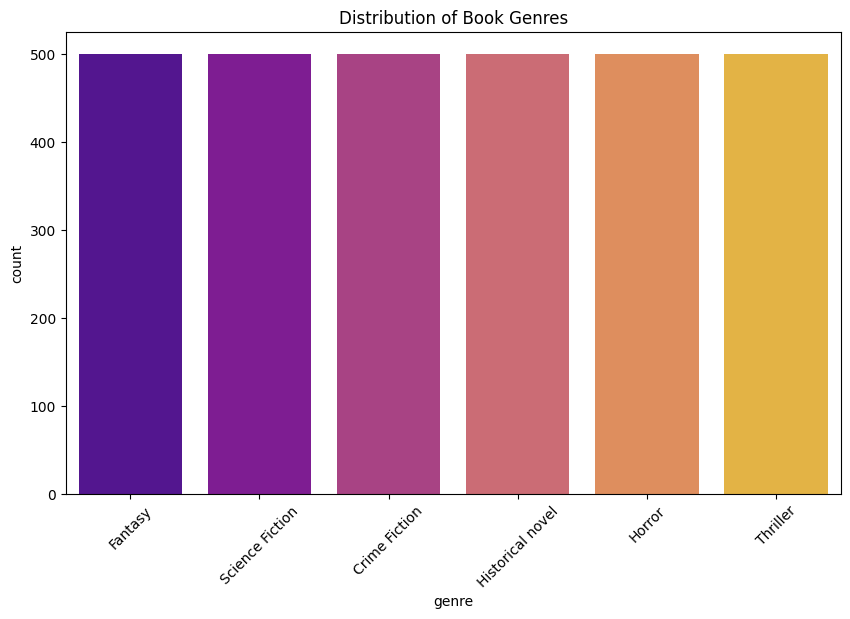

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=books, hue= 'genre', palette='plasma')
plt.title('Distribution of Book Genres')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Display most frequent words
def show_most_frequent_words(text, n_words=25):
    """Show the most frequent words in the text."""
    all_words = ' '.join([word for word in text])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})
    d = words_df.nlargest(columns="count", n=n_words)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=d, x="count", y="word", hue= "count", palette='plasma')
    ax.set(ylabel = 'Word')
    plt.title("Most Frequent Words in Book Summary (Top {} Words)".format(n_words))
    plt.show()
    return words_df

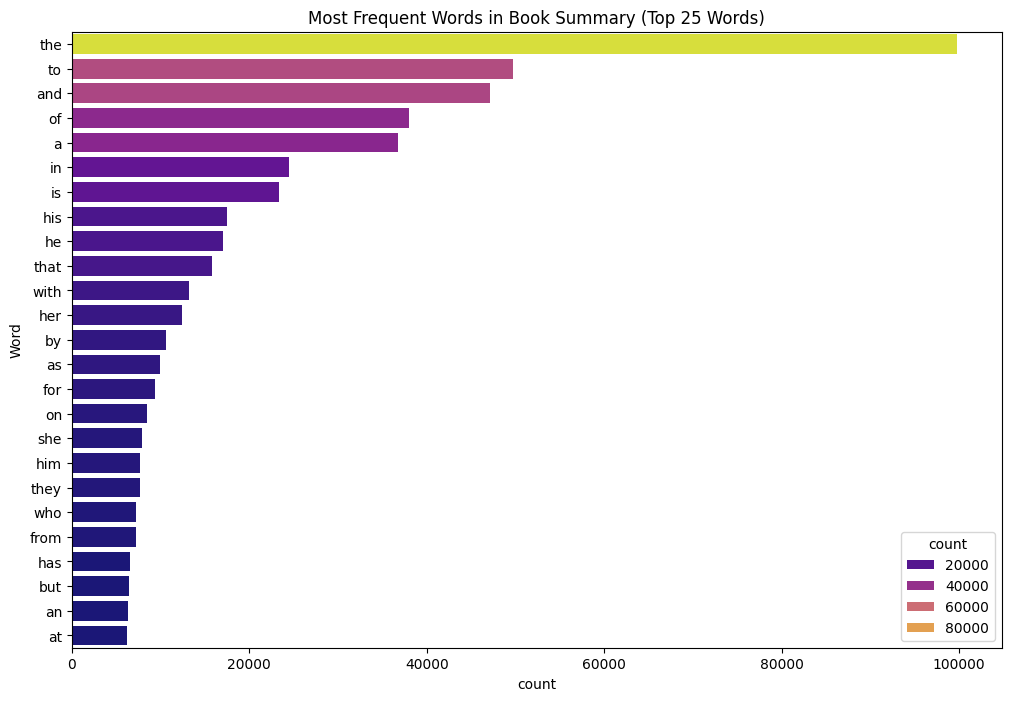

In [9]:
words_df = show_most_frequent_words(books['summary'])

In [10]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return ' '.join([word for word in text.split() if word not in stop_words])

books['summary'] = books['summary'].apply(remove_stopwords)

In [11]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    """Lemmatize the text."""
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

books['summary'] = books['summary'].apply(lemmatize_text)

In [12]:
# Stemming
stemmer = PorterStemmer()

def stem_text(text):
    """Stem the text."""
    return ' '.join([stemmer.stem(word) for word in text.split()])

books['summary'] = books['summary'].apply(stem_text)

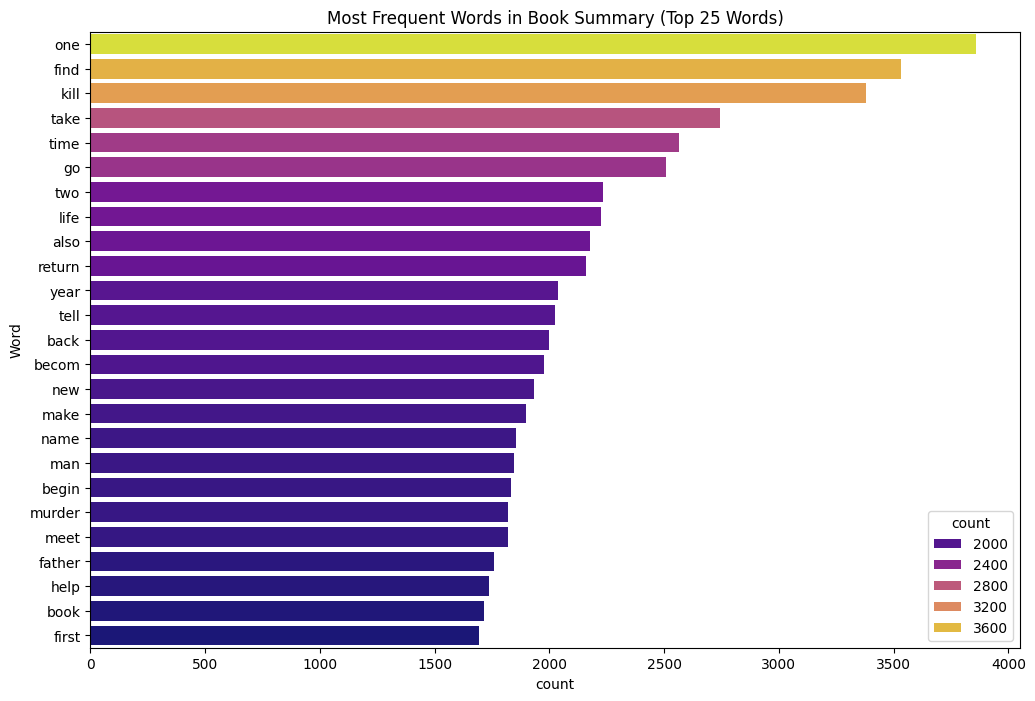

In [13]:
# Show most frequent words after preprocessing
words_df_preprocessed = show_most_frequent_words(books['summary'])

In [14]:
# Encoding genres
le = LabelEncoder()
books['genre_encoded'] = le.fit_transform(books['genre'])

# Model Building - Part 1: CountVectorizer

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(books['summary'], books['genre_encoded'], test_size=0.2, random_state=557)

In [25]:
# CountVectorizer
count_vec = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

In [26]:
# Train and evaluate models
models = {
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier()
}

In [27]:
for name, model in models.items():
    model.fit(X_train_count, y_train)
    y_pred = model.predict(X_test_count)
    print(f"{name} Accuracy with CountVectorizer: {metrics.accuracy_score(y_test, y_pred):.4f}")

SVM Accuracy with CountVectorizer: 0.5783
Naive Bayes Accuracy with CountVectorizer: 0.6917
Random Forest Accuracy with CountVectorizer: 0.6133


# Model Building - Part 2: TfidfVectorizer

In [28]:
# TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train_tfidf = tfidf_vec.fit_transform(X_train.values.astype('U'))
X_test_tfidf = tfidf_vec.transform(X_test.values.astype('U'))

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"{name} Accuracy with TfidfVectorizer: {metrics.accuracy_score(y_test, y_pred):.4f}")

SVM Accuracy with TfidfVectorizer: 0.7750
Naive Bayes Accuracy with TfidfVectorizer: 0.7800
Random Forest Accuracy with TfidfVectorizer: 0.6483


# Model Building - Part 3: Hyperparameter Tuning

In [29]:
# Grid search for SVM
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train_tfidf, y_train)

print("Best parameters for SVM:", grid_svm.best_params_)
print("Best SVM Accuracy:", grid_svm.best_score_)

Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best SVM Accuracy: 0.7033333333333334


In [30]:
# Grid search for Naive Bayes
param_grid_nb = {'alpha': [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train_tfidf, y_train)

print("Best parameters for Naive Bayes:", grid_nb.best_params_)
print("Best Naive Bayes Accuracy:", grid_nb.best_score_)

Best parameters for Naive Bayes: {'alpha': 1.0}
Best Naive Bayes Accuracy: 0.7183333333333333


In [31]:
# Grid search for Random Forest
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train_tfidf, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best Random Forest Accuracy:", grid_rf.best_score_)

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best Random Forest Accuracy: 0.6475000000000001


In [33]:
# Train the best model on the entire dataset
best_model = MultinomialNB()  # MultinomialNB performed the best

X_tfidf = tfidf_vec.fit_transform(books['summary'])
best_model.fit(X_tfidf, books['genre_encoded'])

MultinomialNB()

In [37]:
# Predict genres for all books
books['predicted_genre_encoded'] = best_model.predict(X_tfidf)
books['predicted_genre'] = le.inverse_transform(books['predicted_genre_encoded'])

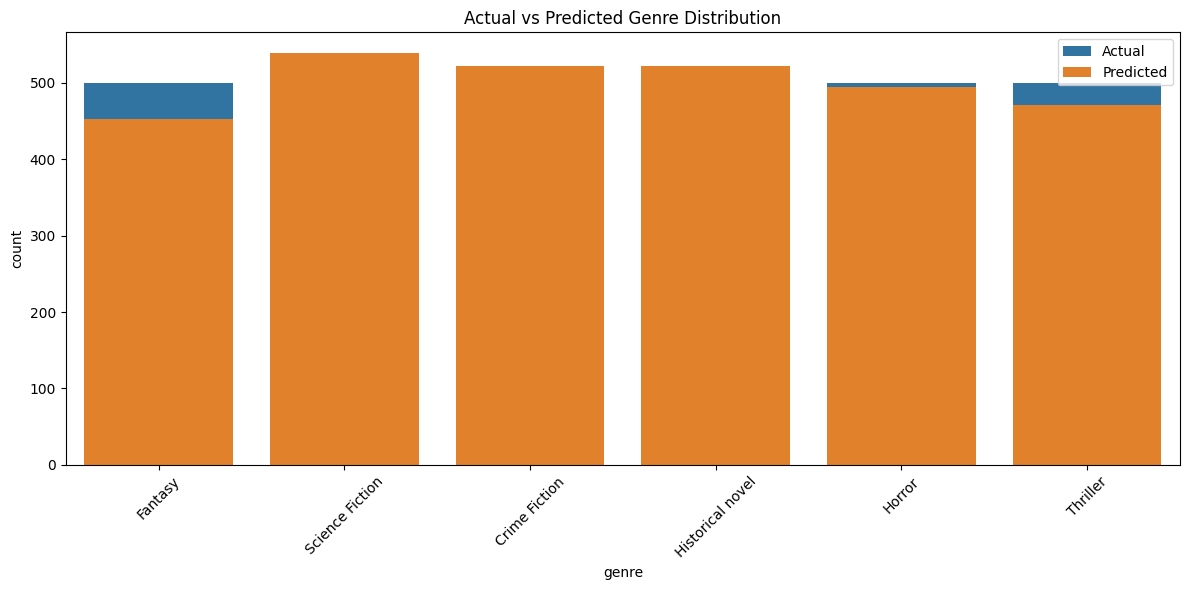

In [38]:
# Plot actual vs predicted genre distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='genre', data=books, label='Actual')
sns.countplot(x='predicted_genre', data=books, label='Predicted')
plt.title('Actual vs Predicted Genre Distribution')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Count and display actual vs predicted genres
actual_counts = books['genre'].value_counts()
predicted_counts = books['predicted_genre'].value_counts()

print("Actual Genre Counts:")
print(actual_counts)
print("\nPredicted Genre Counts:")
print(predicted_counts)

Actual Genre Counts:
genre
Fantasy             500
Science Fiction     500
Crime Fiction       500
Historical novel    500
Horror              500
Thriller            500
Name: count, dtype: int64

Predicted Genre Counts:
predicted_genre
Science Fiction     539
Historical novel    522
Crime Fiction       522
Horror              494
Thriller            471
Fantasy             452
Name: count, dtype: int64


In [40]:
# Calculate and display accuracy
accuracy = (books['genre'] == books['predicted_genre']).mean()
print(f"\nOverall Accuracy: {accuracy:.4f}")


Overall Accuracy: 0.9300


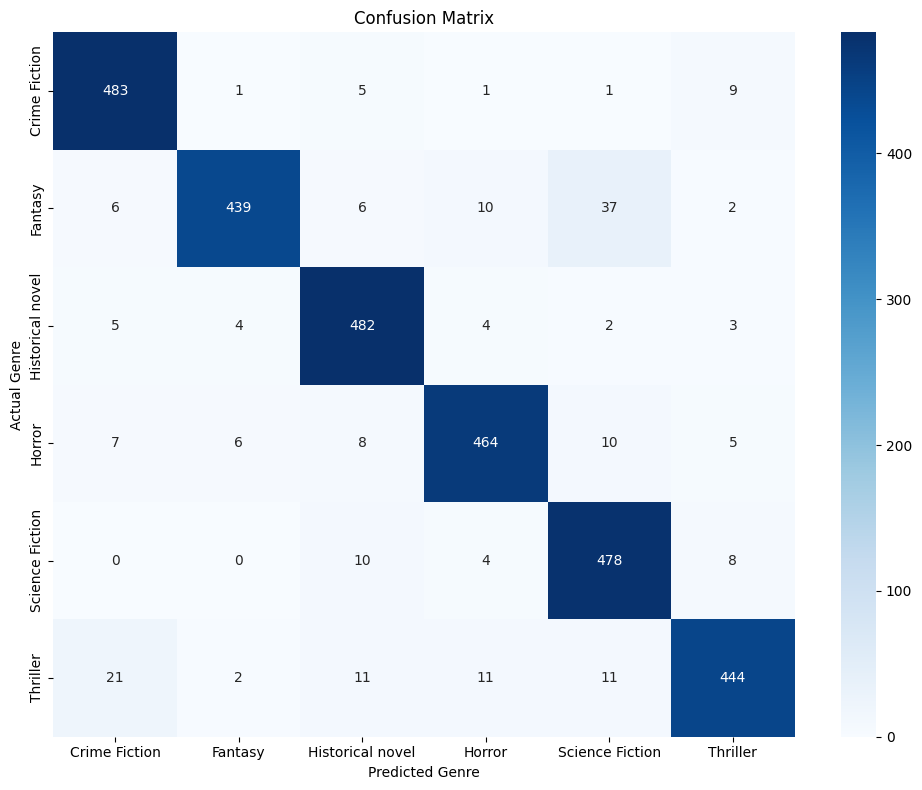

In [41]:
# Display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(books['genre'], books['predicted_genre'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('Actual Genre')
plt.tight_layout()
plt.show()

In [34]:
# Function to predict genre for new summaries
def predict_genre(text):
    """Predict the genre of a given book summary."""
    # Preprocess the input text
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    text = stem_text(text)

    # Transform the text using TfidfVectorizer
    text_tfidf = tfidf_vec.transform([text])

    # Predict the genre
    genre_encoded = best_model.predict(text_tfidf)[0]
    genre = le.inverse_transform([genre_encoded])[0]

    return genre

In [35]:
# Test the model with a sample summary
sample_summary = """
The book tells the story of a young wizard who discovers he has magical powers and is invited to attend a school of witchcraft and wizardry.
"""
predicted_genre = predict_genre(sample_summary)
print(f"Predicted genre for the sample summary: {predicted_genre}")

Predicted genre for the sample summary: Fantasy


In [36]:
# Save the model and necessary objects
joblib.dump(best_model, '/content/drive/MyDrive/ML/Book genre classification/genre_prediction_model.joblib')
joblib.dump(tfidf_vec, '/content/drive/MyDrive/ML/Book genre classification/tfidf_vectorizer.joblib')
joblib.dump(le, '/content/drive/MyDrive/ML/Book genre classification/label_encoder.joblib')

nltk.download('wordnet',download_dir='/content/drive/MyDrive/ML/Book genre classification/')
nltk.download('stopwords',download_dir='/content/drive/MyDrive/ML/Book genre classification/')
print("Model and necessary objects have been saved.")

[nltk_data] Downloading package wordnet to
[nltk_data]     /content/drive/MyDrive/ML/Book genre
[nltk_data]     classification/...
[nltk_data] Downloading package stopwords to
[nltk_data]     /content/drive/MyDrive/ML/Book genre
[nltk_data]     classification/...
[nltk_data]   Unzipping corpora/stopwords.zip.


Model and necessary objects have been saved.
